# Tutorial 2: Semi-Supervised Learning

We will focus on image classification, in particular the setup in which we hav small number of labeled images and large number of unlabeled ones.

## _mixup_

### A bit of theory
Usually, we minimize the average of the loss function $\ell$
over the data distribution $P$, also known as the _expected risk_:
$$R(f) = \int \ell(f(x), y) \mathrm{d} P(x,y).$$
Using the training data $\mathcal{D}$, we may approximate $P$ by the
_empirical distribution_
$$P_\delta(x, y) = \frac{1}{n} \sum_{i=1}^n \delta(x = x_i, y = y_i),$$
resulting in Emprirical Risk Minimization (ERM).

However, there alternitives to ERM. in the Vicinal Risk Minimization (VRM) principle, the distribution $P$ is
approximated by
$$ P_\nu(\tilde{x}, \tilde{y}) = \frac{1}{n} \sum_{i=1}^n \nu(\tilde{x},
\tilde{y} | x_i, y_i), $$
where $\nu$ is a vicinity distribution that measures the probability of
finding the virtual feature-target pair $(\tilde{x}, \tilde{y})$ in the
vicinity of the training feature-target pair $(x_i, y_i)$.

mixup proposed a generic vicinal
distribution:
$$\mu(\tilde{x}, \tilde{y} | x_i, y_i) = \frac{1}{n} \sum_j^n\mathbb{E}_{\lambda} \left[ \delta(\tilde{x}
   = \lambda \cdot x_i + (1-\lambda) \cdot x_j, \tilde{y} = \lambda \cdot y_i +
   (1-\lambda) \cdot y_j) \right],$$
where $\lambda \sim \text{Beta}(\alpha, \alpha)$, for $\alpha \in (0, \infty)$.
In a nutshell, sampling from the mixup vicinal distribution produces virtual
feature-target vectors
$$\tilde{x} = \lambda x_i + (1 - \lambda) x_j,$$
$$\tilde{y} = \lambda y_i + (1 - \lambda) y_j,$$
where $(x_i, y_i)$ and $(x_j, y_j)$ are two feature-target vectors drawn at
random from the training data, and $\lambda \in [0, 1]$. The mixup
hyper-parameter $\alpha$ controls the strength of interpolation between
feature-target pairs, recovering the ERM principle as $\alpha \to 0$.

### Beta distribution

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import beta

In [2]:
def fullseed(seed=42):
    """Sets the random seeds."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


fullseed()

In [3]:
#SETUP
SMALL_SIZE = 10
MEDIUM_SIZE = 18
BIG_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIG_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('xtick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=17)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)
plt.rcParams['axes.axisbelow'] = True

# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
colors = [(230, 25, 75), (60, 180, 75),  #(255, 225, 25),
          (0, 130, 200), (245, 130, 48),
          # (70, 240, 240), 
          (240, 50, 230),
          (250, 190, 212), (0, 128, 128),
          (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0),
          (170, 255, 195), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
#        (255, 250, 200),(170, 255, 195), #seemingly bad
# (250, 190, 190),  (128, 128, 0), (0, 128, 128), (255, 215, 180),(128, 128, 128),(230, 25, 75)] #untested
colors = [[x[0] / 255., x[1] / 255., x[2] / 255.] for x in colors]

Let's take a look on what beta distribution looks like:
![beta](figures/PDF_of_the_Beta_distribution.gif)
We'll focus on distribution with $\alpha=\beta<1$.

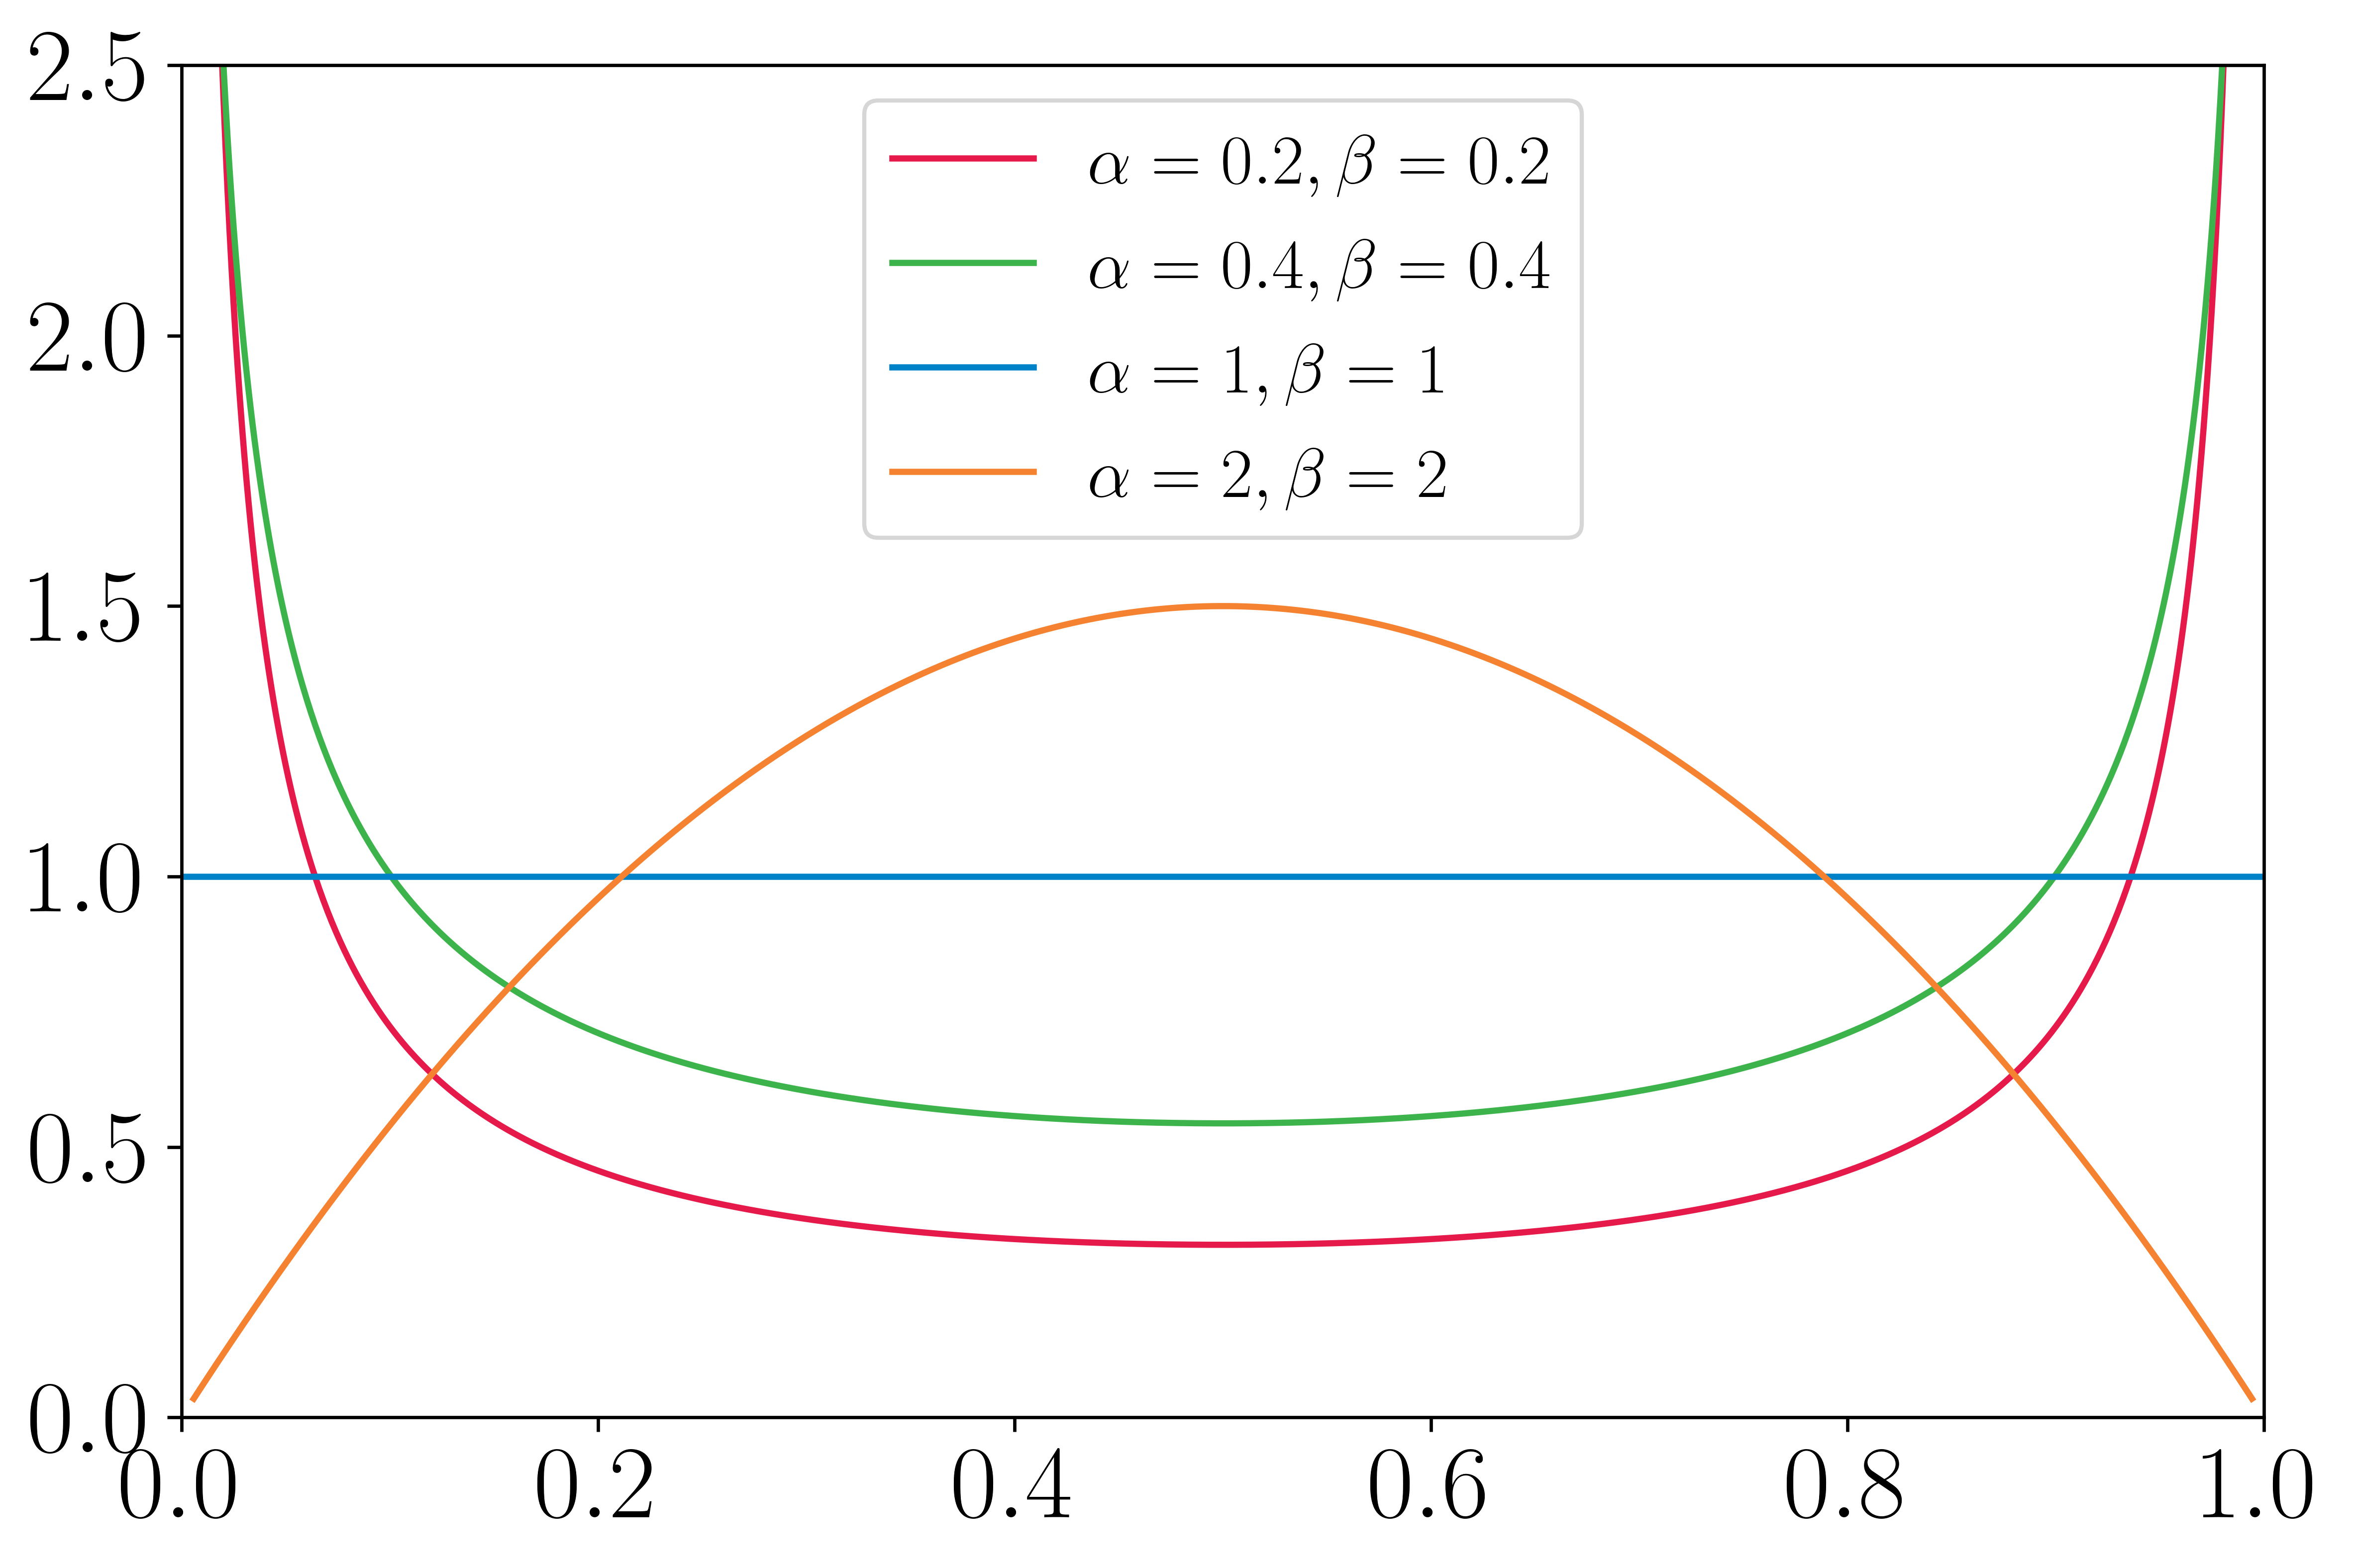

In [4]:
fig = plt.figure(figsize=(9, 6), dpi=600)

params = [[0.2, 0.2], [0.4, 0.4], [1, 1], [2, 2]]
for i, (a, b) in enumerate(params):
    x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 1000)
    plt.plot(x, beta.pdf(x, a, b), color=colors[i], label='$\\alpha={}, \\beta={}$'.format(a, b))
plt.xlim(0, 1)
plt.ylim(0, 2.5)
plt.legend()

In [5]:
!ls figures

n02077923_sea_lion.JPEG  PDF_of_the_Beta_distribution.gif
n02782093_balloon.JPEG


In [6]:
import cv2

In [7]:
img1 = cv2.cvtColor(cv2.imread('figures/n02077923_sea_lion.JPEG'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('figures/n02782093_balloon.JPEG'), cv2.COLOR_BGR2RGB)

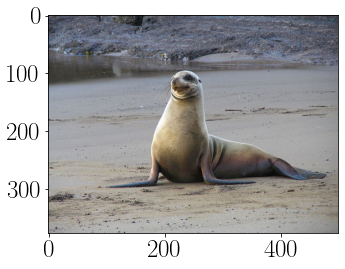

In [8]:
plt.imshow(img1)

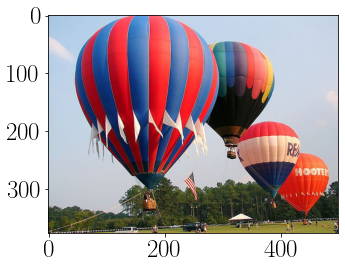

In [9]:
plt.imshow(img2)

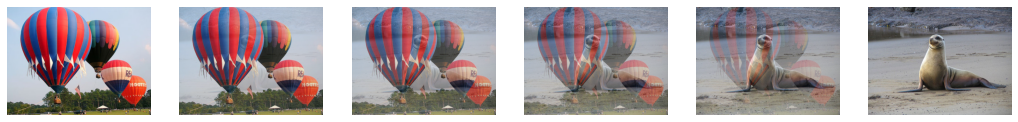

In [10]:
num_images = 6
fig, axs = plt.subplots(1, num_images, figsize=(18, 6))
for i, val in enumerate(np.linspace(0, 1, num_images)):
    axs[i].imshow((val * img1 + (1 - val) * img2).astype(np.int))
    axs[i].set_axis_off()

In [11]:
def onehot(indexes, N=None, ignore_index=None):
    """
    Creates a one-representation of indexes with N possible entries
    if N is not specified, it will suit the maximum index appearing.
    indexes is a long-tensor of indexes
    ignore_index will be zero in onehot representation
    """
    if N is None:
        N = indexes.max() + 1
    sz = list(indexes.size())
    output = indexes.new().byte().resize_(*sz, N).zero_()
    output.scatter_(-1, indexes.unsqueeze(-1), 1)
    if ignore_index is not None and ignore_index >= 0:
        output.masked_fill_(indexes.eq(ignore_index).unsqueeze(-1), 0)
    return output


In [12]:
def mixup_per_sample(x1, y1, x2, y2, alpha=0.75):
    beta_dist = torch.distributions.Beta(torch.tensor([alpha]).to(x1), torch.tensor([alpha]).to(x1))
    l = beta_dist.sample((x1.shape[0],))
    l = l.max(1. - l)  # make sure each sample has "close neighbour"

    mixed_x = l.view(-1, 1, 1, 1) * x1 + (1. - l.view(-1, 1, 1, 1)) * x2
    mixed_y = l.view(-1, 1) * y1 + (1. - l.view(-1, 1)) * y2
    return mixed_x, mixed_y

In [ ]:
def mixup(input_a, input_b, target_a, target_b, alpha):
    l = np.random.beta(alpha, alpha)

    l = max(l, 1 - l)

    mixed_input = l * input_a + (1 - l) * input_b
    mixed_target = l * target_a + (1 - l) * target_b
    return mixed_input, mixed_target


## MixMatch
Let's remind ourselves main components of MixMatch:
- MixUp
- Mixing labeled and unlabeled data
- Distribution averaging: $\bar{q}_b = \frac{1}{K}\sum_k p_{\text{model}}(y \mid \hat{u}_{b, k}; \theta)$
- Temperature sharpening: $\mathrm{sharpen}(p, T)_i := p_i^{\frac{1}{T}}\bigg/ \sum_{j = 1}^L p_j^{\frac{1}{T}}$
- EMA (won't talk about it today)

All those components were ablated by the authors:
![Ablation study for MixMatch](figures/mixmatch_ablation.png)

In [13]:
import math
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils import data
from torch.utils.data import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm, trange



In [14]:
def sharpen(p, T=0.5):
    pt = p ** (1. / T)
    targets_u = pt / pt.sum(dim=1, keepdim=True)
    return targets_u.detach()


In [15]:
def mixmatch(model, inputs_x, targets_x, inputs_u, T=0.5, alpha=0.75):
    # compute guessed labels of unlabeled samples
    unlabeled_predictions = []
    for k in range(inputs_u.shape[1]):
        pred_k = model(inputs_u[:, k])
        unlabeled_predictions.append(pred_k)
    logits_u = torch.stack(unlabeled_predictions, dim=1)
    p = torch.softmax(logits_u, dim=2).mean(dim=1)

    # sharpen
    targets_u = sharpen(p, T=T)

    # mixup
    all_inputs = torch.cat([inputs_x, *[inputs_u[:, k] for k in range(inputs_u.shape[1])]], dim=0)
    all_targets = torch.cat([targets_x, *[targets_u for _ in range(inputs_u.shape[1])]], dim=0)

    idx = torch.randperm(all_inputs.shape[0])

    input_a, input_b = all_inputs, all_inputs[idx]
    target_a, target_b = all_targets, all_targets[idx]

    mixed_input, mixed_target = mixup(input_a, input_b, target_a, target_b, alpha)
    return mixed_input, mixed_target


In [16]:
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]


In [17]:
def train(labeled_trainloader, unlabeled_trainloader, model, optimizer, criterion, epoch, iteration, device,
          dtype, train_iteration, writer, rampup_iter=1., T=0.5, alpha=0.2, w=0., experiment_name=''):
    labeled_train_iter = iter(labeled_trainloader)
    unlabeled_train_iter = iter(unlabeled_trainloader)

    model.train()
    for _ in trange(train_iteration):
        try:
            inputs_x, targets_x = labeled_train_iter.next()
        except StopIteration:
            labeled_train_iter = iter(labeled_trainloader)
            inputs_x, targets_x = labeled_train_iter.next()

        try:
            inputs_u, _ = unlabeled_train_iter.next()
        except StopIteration:
            unlabeled_train_iter = iter(unlabeled_trainloader)
            inputs_u, _ = unlabeled_train_iter.next()

        batch_size = inputs_x.size(0)

        inputs_x, targets_x = inputs_x.to(device=device, dtype=dtype), targets_x.cuda(device=device)
        inputs_u = torch.stack(inputs_u, dim=1).to(device=device, dtype=dtype)

        # Transform label to one-hot
        targets_x = torch.zeros(batch_size, model.fc.out_features).to(targets_x).scatter_(1,
                                                                                          targets_x.view(-1, 1).long(),
                                                                                          1)

        with torch.no_grad():
            mixed_input, mixed_target = mixmatch(model, inputs_x, targets_x, inputs_u, T=T, alpha=alpha)

            targets_x, targets_u = mixed_target[:batch_size], mixed_target[batch_size:]

        curr_w = np.clip(iteration / rampup_iter, 0.0, 1.0) * w
        if curr_w > 0:
            # interleave labeled and unlabeled samples between batches to get correct batchnorm calculation
            mixed_input = list(torch.split(mixed_input, batch_size))
            mixed_input = interleave(mixed_input, batch_size)

            logits = [model(mixed_input[0])]
            for input in mixed_input[1:]:
                logits.append(model(input))

            # put interleaved samples back
            logits = interleave(logits, batch_size)
            logits_x, logits_u = logits[0], torch.cat(logits[1:], dim=0)

            probs_u = torch.softmax(logits_u, dim=1)
            loss_unlabeled = torch.mean((probs_u - targets_u) ** 2)
        else:
            logits_x = model(mixed_input[:batch_size])
            loss_unlabeled = torch.tensor(0)

        loss_labeled = -torch.mean(torch.sum(F.log_softmax(logits_x, dim=1) * targets_x, dim=1))

        loss = loss_labeled + curr_w * loss_unlabeled

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        iteration += 1

        writer.add_scalars('batch/loss', {experiment_name + "_train": loss.item(),
                                          experiment_name + "_train_lab": loss_labeled.item(),
                                          experiment_name + "_train_unlab": loss_unlabeled.item()}, iteration)
        writer.add_scalars('params/lr', {experiment_name: optimizer.param_groups[0]['lr']}, iteration)
        writer.add_scalars('params/w', {experiment_name: curr_w}, iteration)

    return iteration


In [18]:
def correct(output, target, topk=(1,)):
    """Computes the correct@k for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t().type_as(target)
    corr = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = corr[:k].flatten().float().sum(0).item()
        res.append(correct_k)
    return res


In [19]:
def validate(model, loader, epoch, iteration, criterion, device, dtype, writer, experiment_name='', suffix='_val'):
    model.eval()

    test_loss = 0
    correct1 = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(loader)):
            data, target = data.to(device=device, dtype=dtype), target.to(device=device)

            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()  # sum up batch loss
            corr = correct(output, target)
            correct1 += corr[0]

            iteration += 1

        test_loss /= len(loader)
        writer.add_scalars('epoch/loss', {experiment_name + suffix: test_loss}, epoch)
        writer.add_scalars('epoch/top1', {experiment_name + suffix: correct1 / len(loader.sampler)}, epoch)
    return iteration, test_loss, correct1 / len(loader.sampler)


In [20]:
# from https://github.com/facebookresearch/moco/blob/master/moco/loader.py
class MultiCropsTransform:

    def __init__(self, base_transform, k):
        self.k = k
        self.base_transform = base_transform

    def __call__(self, x):
        return [self.base_transform(x) for _ in range(self.k)]


def train_val_split(labels, n_labeled_per_class, val_size=5000, n_classes=10):
    labels = np.array(labels)
    train_labeled_idxs = []
    train_unlabeled_idxs = []
    val_idxs = []

    val_per_class = val_size // n_classes
    for i in range(n_classes):
        idxs = np.where(labels == i)[0]
        np.random.shuffle(idxs)
        train_labeled_idxs.extend(idxs[:n_labeled_per_class])
        train_unlabeled_idxs.extend(idxs[n_labeled_per_class:-val_per_class])
        val_idxs.extend(idxs[-val_per_class:])
    np.random.shuffle(train_labeled_idxs)
    np.random.shuffle(train_unlabeled_idxs)
    np.random.shuffle(val_idxs)

    return train_labeled_idxs, train_unlabeled_idxs, val_idxs


In [21]:
def get_cifar10_loaders(root, labeled_samples_per_class, num_classes, batch_size, workers=0, k=2):
    normalize = torchvision.transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])

    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(size=(32, 32), padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize
    ])

    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        normalize
    ])

    base_dataset = torchvision.datasets.CIFAR10(root, train=True, download=True)
    train_labeled_idxs, train_unlabeled_idxs, val_idxs = train_val_split(base_dataset.targets,
                                                                         int(labeled_samples_per_class))
    print(f"#Labeled: {len(train_labeled_idxs)} #Unlabeled: {len(train_unlabeled_idxs)} #Val: {len(val_idxs)}")

    train_l_data = torchvision.datasets.CIFAR10(root, train=True, transform=train_transform, download=True)
    train_u_data = torchvision.datasets.CIFAR10(root, train=True, transform=MultiCropsTransform(train_transform, k=2),
                                                download=True)
    val_dataset = torchvision.datasets.CIFAR10(root, train=True, transform=test_transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root, train=False, transform=test_transform, download=True)

    labeled_sampler = SubsetRandomSampler(train_labeled_idxs)
    labeled_loader = torch.utils.data.DataLoader(train_l_data, batch_size=batch_size, sampler=labeled_sampler,
                                                 num_workers=workers, drop_last=True)
    unlabeled_sampler = SubsetRandomSampler(train_unlabeled_idxs)
    unlabeled_loader = torch.utils.data.DataLoader(train_u_data, batch_size=batch_size, sampler=unlabeled_sampler,
                                                   num_workers=workers, drop_last=True)
    val_sampler = SubsetRandomSampler(val_idxs)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler,
                                             num_workers=workers, drop_last=True)

    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    return labeled_loader, unlabeled_loader, val_loader, test_loader


In [22]:
def save_checkpoint(state, is_best, filepath='./', filename='checkpoint.pth.tar'):
    save_path = os.path.join(filepath, filename)
    best_path = os.path.join(filepath, 'model_best.pth.tar')
    torch.save(state, save_path)
    if is_best:
        shutil.copyfile(save_path, best_path)


In [ ]:
def train_network(num_iter, optimizer, scheduler, model, train_labeled_loader, train_unlabeled_loader,
                  val_loader, test_loader, criterion, device, dtype, writer, save_path,
                  T=0.5, alpha=0.2, w=0., rampup_iter=1, experiment_name=''):
    best_test = 0
    train_iter, val_iter, test_iter = 0, 0, 0
    epoch_size = 1024
    num_eps = num_iter // epoch_size

    for epoch in trange(num_eps):
        train_iter = train(train_labeled_loader, train_unlabeled_loader, model, optimizer, None, epoch, train_iter,
                           device, dtype, epoch_size, writer, rampup_iter, T=T, alpha=alpha, w=w,
                           experiment_name=experiment_name)

        val_iter, val_loss, val_accuracy1 = validate(model, val_loader, epoch, val_iter, criterion, device, dtype,
                                                     writer, experiment_name=experiment_name, suffix='_val')
        test_iter, test_loss, test_accuracy1 = validate(model, test_loader, epoch, test_iter, criterion, device, dtype,
                                                        writer, experiment_name=experiment_name, suffix='_test')

        best = False
        if val_accuracy1 > best_test:
            best = True
            best_test = val_accuracy1
        save_checkpoint({'epoch': epoch, 'state_dict': model.state_dict(), 'best_prec1': best_test,
                         'optimizer': optimizer.state_dict()}, best, filepath=save_path)

    print('Best accuracy is {:.2f}% top-1'.format(best_test * 100.))


In [ ]:
# code from https://github.com/YU1ut/MixMatch-pytorch
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = nn.Conv2d(in_planes, out_planes,
                                      kernel_size=1, stride=stride,
                                      padding=0, bias=False) if (not self.equalInOut) else None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate,
                                      activate_before_residual)

    @staticmethod
    def _make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate,
                                activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        n_channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert (depth - 4) % 6 == 0
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, n_channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, 1, dropRate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(n_channels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(n_channels[3], num_classes)
        self.n_channels = n_channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.n_channels)
        return self.fc(out)


In [ ]:
# parameters
device = 'cuda:0'
dtype = torch.float32

batch_size = 64

depth = 28
width = 2
dropout = 0.

root = './data'
dataset = 'cifar10'
num_classes = 10 if dataset == 'cifar10' else 100

workers = 0

labeled_samples_per_class = 25

k = 2
T = 0.5
alpha = 0.75
w = 75.
rampup_iter = 2 ** 14
# originally 2^26 iterations
num_iter = 2 ** 17

lr = 2e-3
weight_decay = 4e-5

save_path = './results/cifar10'
os.makedirs(save_path, exist_ok=True)

writer = SummaryWriter(log_dir=save_path)
experiment_name = 'exp32'

In [ ]:
labeled_trainloader, unlabeled_trainloader, val_loader, test_loader = get_cifar10_loaders('./data',
                                                                                          labeled_samples_per_class,
                                                                                          num_classes, batch_size)

In [ ]:
model = WideResNet(num_classes, depth, width, dropout)

num_parameters = sum([layer.nelement() for layer in model.parameters()])
print('Number of parameters'.format(num_parameters))
criterion = nn.CrossEntropyLoss()
model, criterion = model.to(device), criterion.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iter)

In [ ]:
train_network(num_iter, optimizer, scheduler, model, labeled_trainloader, unlabeled_trainloader, val_loader,
              test_loader, criterion, device, dtype, writer, save_path, T=T, alpha=alpha, w=w,
              rampup_iter=rampup_iter, experiment_name=experiment_name)